In [1]:
import numpy as np
import astropy
from astropy.io import fits
from astropy import wcs
import jwst
print('jwst version: ', jwst.__version__, jwst.__file__)
from jwst.assign_wcs import nirspec
from jwst import datamodels

jwst version:  0.9.3a.dev161+g1652b4f7 /Users/dencheva/dev/jwst/jwst/__init__.py


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
#!export CRDS_PATH="/Users/dencheva/crds"
#!export CRDS_SERVER="https://jwst-crds.stsci.edu"
#!/Users/dencheva/dev/jwst/scripts/strun assign_wcs.cfg msa.fits


In [4]:
im = datamodels.ImageModel('msa_assign_wcs.fits')

In [5]:
print("Instrument Configuration")
print("Detector: {}".format(im.meta.instrument.detector))
print("GWA: {}".format(im.meta.instrument.grating))
print("Filter: {}".format(im.meta.instrument.filter))
print("Lamp: {}".format(im.meta.instrument.lamp_state))
print("GWA_XTILT: {}".format(im.meta.instrument.gwa_xtilt))
print("GWA_YTILT: {}".format(im.meta.instrument.gwa_ytilt))
print("GWA_TTILT: {}".format(im.meta.instrument.gwa_tilt))
      

Instrument Configuration
Detector: NRS1
GWA: G395M
Filter: OPAQUE
Lamp: LINE3
GWA_XTILT: 0.2856041491031647
GWA_YTILT: 0.1789360195398331
GWA_TTILT: 40.28447479156018


In [6]:
# Compute percentage of pixels above certain threshold
def compute_percentage(values, threshold):
    values = values[~np.isnan(values)]
    n_total = values.size
    
    thresh = [threshold, 3*threshold, 5*threshold]
    res = []
    for i in thresh:
        n = np.logical_or(values > i, values< -i).nonzero()[0].size
        res.append((n / n_total) * 100)
    return res
    

In [7]:
def stats_and_plots(diff, notnan, slit_id, frame, threshold=1e-7):
    percentage_results = compute_percentage(diff, threshold)
    
    # Compute statistics
    mean = np.mean(diff[notnan])
    median = np.median(diff[notnan])
    dmax = np.max(diff[notnan])
    dmin = np.min(diff[notnan])
    dstd = np.std(diff[notnan])
    
    title1 = "Slit {0}: relative {1} difference\n".format(slit_id, frame)
    title1 += "Mean: {}\n".format(mean)
    title1 += "Median: {}\n".format(median)
    title1 += "Max: {}\n".format(dmax)
    title1 += "Min: {}\n".format(dmin)
    title1 += "Std: {}\n".format(dstd)
    
    title2 = "histogram of {} diff\n".format(frame)
    title2 += "Percentage of points above 1x threshold: {}\n".format(percentage_results[0])
    title2 += "Percentage of points above 3x threshold: {}\n".format(percentage_results[1])
    title2 += "Percentage of points above 5x threshold: {}\n".format(percentage_results[2])
    
    fig = plt.figure(figsize=(15, 5))
    ax1 = plt.subplot(1,2,1)
    i1 = ax1.imshow(diff, aspect='auto')
    plt.title(title1)
    plt.colorbar(i1, ax=ax1 )
    plt.xlabel('x, pix')
    plt.ylabel('y, pix')
    ax2 = plt.subplot(1,2,2)
    i2 = plt.hist(diff[~np.isnan(diff)].flatten(), bins=10)
    ax2.plot([mean]*2, [0,160], label="mean: {:3.2e}".format(mean))
    ax2.plot([median]*2, [0,160], label="median: {:3.2e}".format(median))
    ax2.legend()
    plt.title(title2)
    plt.xlabel('relative difference in {}'.format(frame))
    plt.ylabel('n')
    fig.tight_layout()

2018-04-28 10:15:01,755 - stpipe - INFO - Retrieving open slitlets for msa_metadata_id = 1


Open slits
[Slit(name=1, shutter_id=4699, xcen=319, ycen=13, ymin=-0.55, ymax=0.55, quadrant=3, source_id=1, shutter_state='x', source_name='lamp', source_alias='foo', stellarity=100.0, source_xpos=-0.5, source_ypos=0.5)]


2018-04-28 10:15:02,353 - stpipe - WARNING - /Users/dencheva/anaconda3/envs/jwstdev/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide



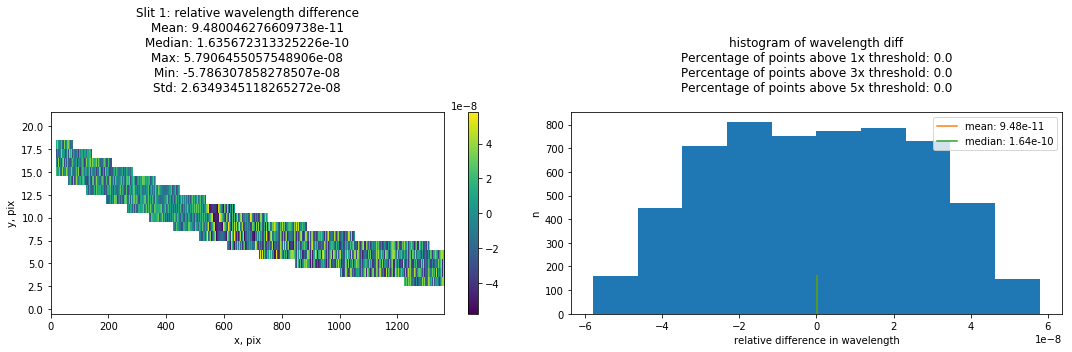

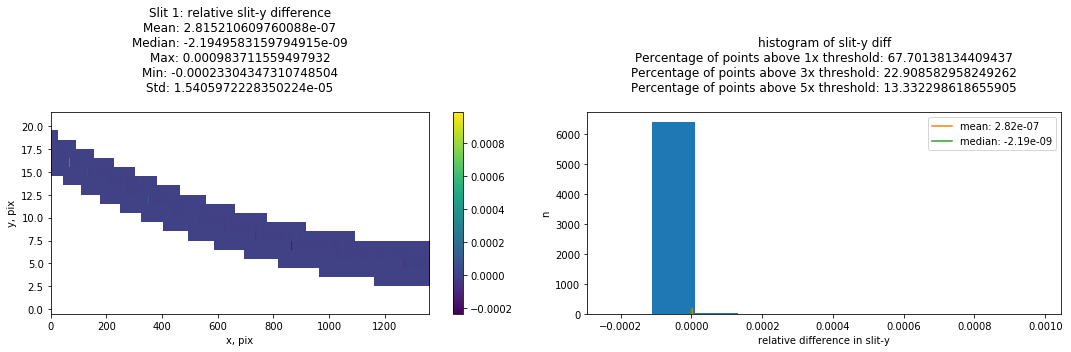

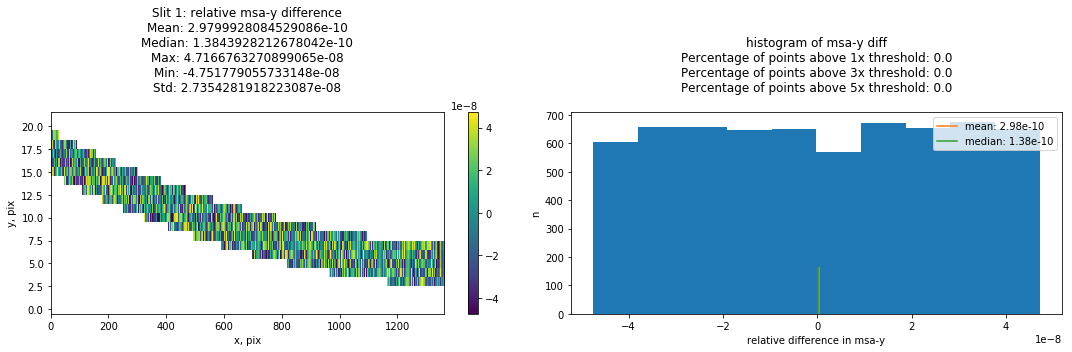

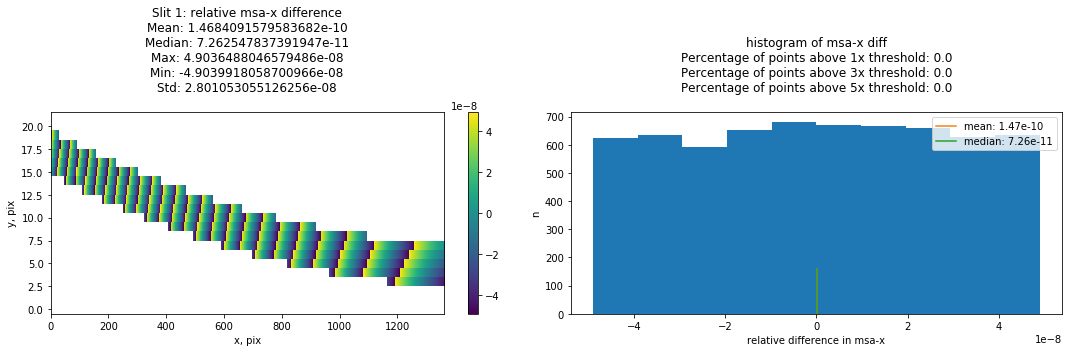

In [8]:
trace = "Trace_MOS_3_319_013_V96215001001P0000000002103_41543_JLAB88.fits"
tr = fits.open(trace)
lam1 = tr['LAMBDA1'].data
slit1 = tr['SLITY1'].data
msay1 = tr['MSAY1'].data
msax1 = tr['MSAX1'].data
pyw = wcs.WCS(tr[4].header)
tr.close()

# Create x, y indices using the Trace WCS
y, x = np.mgrid[:lam1.shape[0], : lam1.shape[1]]
x1, y1 = pyw.all_pix2world(x, y, 0)

# Get the WCS for this particular slice
slits = nirspec.get_open_slits(im)
print("Open slits")
print(slits)
name = slits[0].name

wcs_slit = nirspec.nrs_wcs_set_input(im, name)

# Compute ra, dec and lambda
ra, dec, lam = wcs_slit(x1-1, y1-1) #use 0-based coordinates
lam *= 10**-6

# Compute indices for slit-y between -.5 and .5
in_slit = np.logical_and(slit1<.5, slit1>-.5)
lam[~in_slit] = np.nan
nanind = np.isnan(lam)
notnan = ~nanind
    
# Compute the difference in wavelength
diff = (lam - lam1) / lam1
stats_and_plots(diff, notnan, name, "wavelength")

# Compute slit-y and positions on the MSA
detector2slit = wcs_slit.get_transform('detector', 'slit_frame')
sx, sy, _ = detector2slit(x1-1, y1-1)
diffslit = (sy - slit1) / slit1
stats_and_plots(diffslit, notnan, name, "slit-y")

detector2msa = wcs_slit.get_transform('detector', 'msa_frame')
mx, my, _ = detector2msa(x1-1, y1-1)
diffmsay = (my - msay1) / msay1
stats_and_plots(diffmsay, notnan, name, "msa-y")

diffmsax = (mx - msax1) / msax1
stats_and_plots(diffmsax, notnan, name, "msa-x")
